<a href="https://colab.research.google.com/github/Panossyki/gregor-process-mining-thesis/blob/main/Copy_of_Prosess_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install pm4py pandas numpy matplotlib graphviz

# (ΠΡΟΑΙΡΕΤΙΚΟ αλλά βοηθάει σε κάποια Colab runtimes)
!apt-get -qq update
!apt-get -qq install -y graphviz
print("✅ Installed")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ Installed


In [ ]:
from google.colab import files
uploaded = files.upload()  # ανέβασε new_dump.json


Saving new_dump.json to new_dump.json


In [ ]:
import json
import pandas as pd
import numpy as np

INPUT = "new_dump.json"

records = []
with open(INPUT, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        records.append(json.loads(line))

df_raw = pd.DataFrame(records)
print("✅ Raw events:", len(df_raw))
df_raw.head(5)


✅ Raw events: 685


,time,level,msg,Robot,Task,Chair,Caller,Workbench,Fixture,Storage,Item,From,Component,Conveyor Belt,Number of chair:
0,2025-06-02T19:48:54.669134951+03:00,INFO,Robot started task,Robot1,AssemblyTask1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-02T19:48:54.669231973+03:00,INFO,Fixture requested,NaN,AssemblyTask1,1.0,Robot1,Workbench1,Fixture1,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-06-02T19:48:54.669451644+03:00,INFO,Fixture request granted,NaN,AssemblyTask1,1.0,Robot1,Workbench1,Fixture1,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-06-02T19:48:56.317908843+03:00,INFO,Robot moved to storage,Robot1,AssemblyTask1,1.0,NaN,NaN,NaN,StorageB2,NaN,NaN,NaN,NaN,NaN
4,2025-06-02T19:48:57.438023753+03:00,INFO,Robot picked up item,Robot1,AssemblyTask1,1.0,NaN,NaN,NaN,NaN,Base,StorageB2,NaN,NaN,NaN


In [ ]:
import pm4py

KEPT_MSGS = {"Robot started task", "Robot ended task", "Chair assembled"}

def build_gregor_event_log_v1(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    # keep only V1 messages
    df = df[df["msg"].isin(KEPT_MSGS)].copy()

    # timestamp
    df["time:timestamp"] = pd.to_datetime(df["time"], errors="coerce", utc=True)

    # case id: prefer Chair; else parse "Number of chair:"
    chair_from_number = pd.to_numeric(df.get("Number of chair:", pd.Series([np.nan]*len(df))), errors="coerce")
    df["case:concept:name"] = pd.to_numeric(df.get("Chair", pd.Series([np.nan]*len(df))), errors="coerce")
    df["case:concept:name"] = df["case:concept:name"].fillna(chair_from_number)

    # activity mapping (όπως το report v1)
    df["concept:name"] = np.where(
        df["msg"].eq("Robot started task"),
        df["Task"].astype(str) + ":start",
        np.where(
            df["msg"].eq("Robot ended task"),
            df["Task"].astype(str) + ":end",
            "Chair:assembled"
        )
    )

    # keep attributes we want to carry
    keep_cols = [
        "case:concept:name", "concept:name", "time:timestamp",
        "Robot", "Task", "Caller", "Workbench", "Fixture",
        "Storage", "Item", "From", "Component", "Conveyor Belt",
        "level", "msg"
    ]
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].copy()

    # drop rows missing core columns
    before = len(df)
    df = df.dropna(subset=["case:concept:name", "time:timestamp", "concept:name"]).copy()
    dropped = before - len(df)

    # format for pm4py
    df = pm4py.format_dataframe(
        df,
        case_id="case:concept:name",
        activity_key="concept:name",
        timestamp_key="time:timestamp"
    )
    return df, dropped

event_log_v1, dropped = build_gregor_event_log_v1(df_raw)

print("✅ v1 events:", len(event_log_v1))
print("✅ v1 traces:", event_log_v1["case:concept:name"].nunique())
print("✅ v1 activities:", event_log_v1["concept:name"].nunique())
print("Dropped (missing case or ts):", dropped)

event_log_v1.head(15)


✅ v1 events: 116
✅ v1 traces: 8
✅ v1 activities: 17
Dropped (missing case or ts): 0


,case:concept:name,concept:name,time:timestamp,Robot,Task,Caller,Workbench,Fixture,Storage,Item,From,Component,Conveyor Belt,level,msg,@@index,@@case_index
0,1.0,AssemblyTask1:start,2025-06-02 16:48:54.669134951+00:00,Robot1,AssemblyTask1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot started task,0,0
1,1.0,AssemblyTask1:end,2025-06-02 16:49:13.804876476+00:00,Robot1,AssemblyTask1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot ended task,1,0
2,1.0,AssemblyTask4:start,2025-06-02 16:49:13.805650113+00:00,Robot1,AssemblyTask4,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot started task,2,0
3,1.0,AssemblyTask2:start,2025-06-02 16:49:14.965546910+00:00,Robot2,AssemblyTask2,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot started task,3,0
4,1.0,AssemblyTask2:end,2025-06-02 16:49:27.117073077+00:00,Robot2,AssemblyTask2,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot ended task,4,0
5,1.0,AssemblyTask3:start,2025-06-02 16:49:27.117827158+00:00,Robot2,AssemblyTask3,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot started task,5,0
6,1.0,AssemblyTask4:end,2025-06-02 16:49:33.161996752+00:00,Robot1,AssemblyTask4,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot ended task,6,0
7,1.0,AssemblyTask3:end,2025-06-02 16:49:38.800137427+00:00,Robot2,AssemblyTask3,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot ended task,7,0
8,1.0,AssemblyTask5:start,2025-06-02 16:49:38.800718904+00:00,Robot2,AssemblyTask5,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot started task,8,0
9,1.0,AssemblyTask5:end,2025-06-02 16:49:50.987889050+00:00,Robot2,AssemblyTask5,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,INFO,Robot ended task,9,0


In [ ]:
from google.colab import files

event_log_v1.to_csv("gregor_event_log_v1.csv", index=False)

log_obj = pm4py.convert_to_event_log(event_log_v1)
pm4py.write_xes(log_obj, "gregor_event_log_v1.xes")

print("✅ Saved: gregor_event_log_v1.csv, gregor_event_log_v1.xes")


/usr/local/lib/python3.12/dist-packages/pm4py/utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


exporting log, completed traces ::   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved: gregor_event_log_v1.csv, gregor_event_log_v1.xes


In [ ]:
import pm4py

log_obj = pm4py.convert_to_event_log(event_log_v1)

models = {}

# Alpha Miner
net_a, im_a, fm_a = pm4py.discover_petri_net_alpha(log_obj)
models["alpha"] = (net_a, im_a, fm_a)

# Inductive Miner
net_i, im_i, fm_i = pm4py.discover_petri_net_inductive(log_obj)
models["inductive"] = (net_i, im_i, fm_i)

# Heuristics Miner
net_h, im_h, fm_h = pm4py.discover_petri_net_heuristics(log_obj)
models["heuristics"] = (net_h, im_h, fm_h)

# Save figures
for name, (net, im, fm) in models.items():
    gviz = pm4py.visualization.petri_net.visualizer.apply(net, im, fm)
    pm4py.visualization.petri_net.visualizer.save(gviz, f"{name}_petri.png")

print("✅ Saved: alpha_petri.png, inductive_petri.png, heuristics_petri.png")


✅ Saved: alpha_petri.png, inductive_petri.png, heuristics_petri.png


In [ ]:
from google.colab import files

for fn in ["alpha_petri.png", "inductive_petri.png", "heuristics_petri.png"]:
    files.download(fn)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import pm4py

results = []

for name, (net, im, fm) in models.items():
    row = {"model": name}

    # Token-based replay fitness
    tbr = pm4py.fitness_token_based_replay(log_obj, net, im, fm)
    row["tbr_log_fitness"] = float(tbr.get("log_fitness", np.nan))
    row["tbr_avg_trace_fitness"] = float(tbr.get("average_trace_fitness", np.nan))
    row["tbr_perc_fit_traces"] = float(tbr.get("percentage_of_fitting_traces", np.nan))

    # Alignments-based fitness + precision (μπορεί να αποτύχει σε κάποια nets, π.χ. alpha)
    try:
        af = pm4py.fitness_alignments(log_obj, net, im, fm)
        row["align_log_fitness"] = float(af.get("log_fitness", np.nan))
        row["align_avg_trace_fitness"] = float(af.get("average_trace_fitness", np.nan))
        row["align_perc_fit_traces"] = float(af.get("percentage_of_fitting_traces", np.nan))

        prec = pm4py.precision_alignments(log_obj, net, im, fm)
        row["align_precision"] = float(prec)
        row["notes"] = None
    except Exception as e:
        row["align_log_fitness"] = np.nan
        row["align_avg_trace_fitness"] = np.nan
        row["align_perc_fit_traces"] = np.nan
        row["align_precision"] = np.nan
        row["notes"] = str(e)

    results.append(row)

df_conf = pd.DataFrame(results)
df_conf.to_csv("gregor_v1_conformance_results.csv", index=False)
print("✅ Saved: gregor_v1_conformance_results.csv")
df_conf


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/34 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/34 [00:00<?, ?it/s]

✅ Saved: gregor_v1_conformance_results.csv


,model,tbr_log_fitness,tbr_avg_trace_fitness,tbr_perc_fit_traces,align_log_fitness,align_avg_trace_fitness,align_perc_fit_traces,align_precision,notes
0,alpha,0.900539,0.899922,0.0,NaN,NaN,NaN,NaN,trying to apply alignments on a Petri net that...
1,inductive,1.000000,1.000000,100.0,0.999998,1.000000,100.0,0.87500,None
2,heuristics,0.993506,0.994048,87.5,0.992841,0.993421,87.5,0.89313,None


In [ ]:
case_times = (
    event_log_v1
    .groupby("case:concept:name")["time:timestamp"]
    .agg(case_start="min", case_end="max")
    .reset_index()
)

case_times["throughput_sec"] = (case_times["case_end"] - case_times["case_start"]).dt.total_seconds()

case_times.to_csv("gregor_v1_case_throughput.csv", index=False)
print("✅ Saved: gregor_v1_case_throughput.csv")
case_times


✅ Saved: gregor_v1_case_throughput.csv


,case:concept:name,case_start,case_end,throughput_sec
0,1.0,2025-06-02 16:48:54.669134951+00:00,2025-06-02 16:50:36.353494311+00:00,101.684359
1,2.0,2025-06-02 16:49:33.162443047+00:00,2025-06-02 16:51:19.738583598+00:00,106.576141
2,3.0,2025-06-02 16:50:12.173023548+00:00,2025-06-02 16:52:02.885077283+00:00,110.712054
3,4.0,2025-06-02 16:50:50.165264006+00:00,2025-06-02 16:52:46.192624782+00:00,116.027361
4,5.0,2025-06-02 16:51:27.540507480+00:00,2025-06-02 16:53:30.439066419+00:00,122.898559
5,6.0,2025-06-02 16:52:05.847080809+00:00,2025-06-02 16:54:13.856942964+00:00,128.009862
6,7.0,2025-06-02 16:52:48.846674520+00:00,2025-06-02 16:54:13.835397166+00:00,84.988723
7,8.0,2025-06-02 16:53:32.774963178+00:00,2025-06-02 16:53:52.377162146+00:00,19.602199


In [ ]:
import re

df = event_log_v1.copy()
df = df.sort_values(["case:concept:name", "time:timestamp"])

# isolate task start/end events
mask = df["concept:name"].str.contains(r"^AssemblyTask\d+:(start|end)$", regex=True, na=False)
df_tasks = df[mask].copy()

df_tasks["task"] = df_tasks["concept:name"].str.replace(r":(start|end)$", "", regex=True)
df_tasks["lifecycle"] = df_tasks["concept:name"].str.extract(r":(start|end)$", expand=False)

pairs = []

for case_id, g in df_tasks.groupby("case:concept:name"):
    # for each task, pair in time order
    for task, gt in g.groupby("task"):
        gt = gt.sort_values("time:timestamp")
        starts = gt[gt["lifecycle"] == "start"]
        ends = gt[gt["lifecycle"] == "end"]

        # naive pairing by order (works well if log is clean)
        n = min(len(starts), len(ends))
        for i in range(n):
            s = starts.iloc[i]
            e = ends.iloc[i]
            dur = (e["time:timestamp"] - s["time:timestamp"]).total_seconds()
            pairs.append({
                "case:concept:name": case_id,
                "task": task,
                "start_ts": s["time:timestamp"],
                "end_ts": e["time:timestamp"],
                "duration_sec": dur,
                "Robot_start": s.get("Robot", None),
                "Robot_end": e.get("Robot", None),
            })

task_durations = pd.DataFrame(pairs)
task_durations.to_csv("gregor_v1_task_durations.csv", index=False)
print("✅ Saved: gregor_v1_task_durations.csv")
task_durations.head(10)


✅ Saved: gregor_v1_task_durations.csv


/tmp/ipython-input-1200941636.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["concept:name"].str.contains(r"^AssemblyTask\d+:(start|end)$", regex=True, na=False)


,case:concept:name,task,start_ts,end_ts,duration_sec,Robot_start,Robot_end
0,1.0,AssemblyTask1,2025-06-02 16:48:54.669134951+00:00,2025-06-02 16:49:13.804876476+00:00,19.135741,Robot1,Robot1
1,1.0,AssemblyTask2,2025-06-02 16:49:14.965546910+00:00,2025-06-02 16:49:27.117073077+00:00,12.151526,Robot2,Robot2
2,1.0,AssemblyTask3,2025-06-02 16:49:27.117827158+00:00,2025-06-02 16:49:38.800137427+00:00,11.682310,Robot2,Robot2
3,1.0,AssemblyTask4,2025-06-02 16:49:13.805650113+00:00,2025-06-02 16:49:33.161996752+00:00,19.356346,Robot1,Robot1
4,1.0,AssemblyTask5,2025-06-02 16:49:38.800718904+00:00,2025-06-02 16:49:50.987889050+00:00,12.187170,Robot2,Robot2
5,1.0,AssemblyTask6,2025-06-02 16:49:50.988417549+00:00,2025-06-02 16:50:08.178516445+00:00,17.190098,Robot3,Robot3
6,1.0,AssemblyTask7,2025-06-02 16:50:22.313988581+00:00,2025-06-02 16:50:36.332073806+00:00,14.018085,Robot3,Robot3
7,2.0,AssemblyTask1,2025-06-02 16:49:33.162443047+00:00,2025-06-02 16:49:52.818710681+00:00,19.656267,Robot1,Robot1
8,2.0,AssemblyTask2,2025-06-02 16:49:54.066506862+00:00,2025-06-02 16:50:06.335859662+00:00,12.269352,Robot2,Robot2
9,2.0,AssemblyTask3,2025-06-02 16:50:06.336412877+00:00,2025-06-02 16:50:18.013327988+00:00,11.676915,Robot2,Robot2


In [ ]:
import re

df = event_log_v1.copy()
df = df.sort_values(["case:concept:name", "time:timestamp"])

# isolate task start/end events
mask = df["concept:name"].str.contains(r"^AssemblyTask\d+:(start|end)$", regex=True, na=False)
df_tasks = df[mask].copy()

df_tasks["task"] = df_tasks["concept:name"].str.replace(r":(start|end)$", "", regex=True)
df_tasks["lifecycle"] = df_tasks["concept:name"].str.extract(r":(start|end)$", expand=False)

pairs = []

for case_id, g in df_tasks.groupby("case:concept:name"):
    # for each task, pair in time order
    for task, gt in g.groupby("task"):
        gt = gt.sort_values("time:timestamp")
        starts = gt[gt["lifecycle"] == "start"]
        ends = gt[gt["lifecycle"] == "end"]

        # naive pairing by order (works well if log is clean)
        n = min(len(starts), len(ends))
        for i in range(n):
            s = starts.iloc[i]
            e = ends.iloc[i]
            dur = (e["time:timestamp"] - s["time:timestamp"]).total_seconds()
            pairs.append({
                "case:concept:name": case_id,
                "task": task,
                "start_ts": s["time:timestamp"],
                "end_ts": e["time:timestamp"],
                "duration_sec": dur,
                "Robot_start": s.get("Robot", None),
                "Robot_end": e.get("Robot", None),
            })

task_durations = pd.DataFrame(pairs)
task_durations.to_csv("gregor_v1_task_durations.csv", index=False)
print("✅ Saved: gregor_v1_task_durations.csv")
task_durations.head(10)


/tmp/ipython-input-1200941636.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["concept:name"].str.contains(r"^AssemblyTask\d+:(start|end)$", regex=True, na=False)


✅ Saved: gregor_v1_task_durations.csv


,case:concept:name,task,start_ts,end_ts,duration_sec,Robot_start,Robot_end
0,1.0,AssemblyTask1,2025-06-02 16:48:54.669134951+00:00,2025-06-02 16:49:13.804876476+00:00,19.135741,Robot1,Robot1
1,1.0,AssemblyTask2,2025-06-02 16:49:14.965546910+00:00,2025-06-02 16:49:27.117073077+00:00,12.151526,Robot2,Robot2
2,1.0,AssemblyTask3,2025-06-02 16:49:27.117827158+00:00,2025-06-02 16:49:38.800137427+00:00,11.682310,Robot2,Robot2
3,1.0,AssemblyTask4,2025-06-02 16:49:13.805650113+00:00,2025-06-02 16:49:33.161996752+00:00,19.356346,Robot1,Robot1
4,1.0,AssemblyTask5,2025-06-02 16:49:38.800718904+00:00,2025-06-02 16:49:50.987889050+00:00,12.187170,Robot2,Robot2
5,1.0,AssemblyTask6,2025-06-02 16:49:50.988417549+00:00,2025-06-02 16:50:08.178516445+00:00,17.190098,Robot3,Robot3
6,1.0,AssemblyTask7,2025-06-02 16:50:22.313988581+00:00,2025-06-02 16:50:36.332073806+00:00,14.018085,Robot3,Robot3
7,2.0,AssemblyTask1,2025-06-02 16:49:33.162443047+00:00,2025-06-02 16:49:52.818710681+00:00,19.656267,Robot1,Robot1
8,2.0,AssemblyTask2,2025-06-02 16:49:54.066506862+00:00,2025-06-02 16:50:06.335859662+00:00,12.269352,Robot2,Robot2
9,2.0,AssemblyTask3,2025-06-02 16:50:06.336412877+00:00,2025-06-02 16:50:18.013327988+00:00,11.676915,Robot2,Robot2


In [ ]:
task_stats = (
    task_durations
    .groupby("task")["duration_sec"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)

task_stats.to_csv("gregor_v1_task_duration_stats.csv", index=False)
print("✅ Saved: gregor_v1_task_duration_stats.csv")
task_stats


✅ Saved: gregor_v1_task_duration_stats.csv


,task,count,mean,median,std,min,max
0,AssemblyTask1,8,19.616318,19.649378,0.371178,19.044703,20.165006
1,AssemblyTask2,7,12.139838,12.120457,0.092000,12.046884,12.269352
2,AssemblyTask3,7,11.730555,11.674162,0.203855,11.558712,12.182233
3,AssemblyTask4,7,20.109649,19.353255,2.537675,18.126581,24.106784
4,AssemblyTask5,7,12.305977,12.288302,0.149682,12.071090,12.529766
5,AssemblyTask6,6,15.520530,15.209803,0.825348,15.070393,17.190098
6,AssemblyTask7,6,14.213226,14.027758,0.432404,14.017110,15.093850
7,AssemblyTask8,5,-29.438698,-29.185535,0.572533,-30.455445,-29.089123


In [ ]:
def compute_fixture_wait_times(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()
    df["ts"] = pd.to_datetime(df["time"], errors="coerce", utc=True)
    df = df.dropna(subset=["ts", "msg"]).sort_values("ts").copy()

    req = df[df["msg"] == "Fixture requested"].copy()
    grn = df[df["msg"] == "Fixture request granted"].copy()

    # Κλειδί που “δένει” request με grant.
    # (Το Chair μπορεί να μην ταιριάζει πάντα, άρα ΔΕΝ το βάζουμε στο key)
    key_cols = ["Task", "Caller", "Workbench", "Fixture"]
    for c in key_cols:
        if c not in df.columns:
            df[c] = np.nan

    # queue ανά key (πολλαπλά outstanding requests)
    queues = {}
    rows = []

    def make_key(r):
        return tuple(r.get(c, None) for c in key_cols)

    for _, r in req.iterrows():
        k = make_key(r)
        queues.setdefault(k, []).append(r)

    # κάνουμε δεύτερο πέρασμα με grants, σε χρονολογική σειρά, και “τραβάμε” το παλαιότερο request
    queues = {}
    for _, r in req.sort_values("ts").iterrows():
        k = make_key(r)
        queues.setdefault(k, []).append(r)

    for _, g in grn.sort_values("ts").iterrows():
        k = make_key(g)
        if k not in queues or len(queues[k]) == 0:
            continue
        r = queues[k].pop(0)
        rows.append({
            "Task": g.get("Task", None),
            "Caller": g.get("Caller", None),
            "Workbench": g.get("Workbench", None),
            "Fixture": g.get("Fixture", None),
            "request_ts": r["ts"],
            "grant_ts": g["ts"],
            "wait_sec": (g["ts"] - r["ts"]).total_seconds(),
            "chair_req": r.get("Chair", np.nan),
            "chair_grant": g.get("Chair", np.nan),
        })

    return pd.DataFrame(rows)

fixture_wait_times = compute_fixture_wait_times(df_raw)
fixture_wait_times.to_csv("gregor_v2_fixture_wait_times.csv", index=False)

fixture_wait_stats = (
    fixture_wait_times
    .groupby(["Workbench", "Fixture", "Task", "Caller"])["wait_sec"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
    .sort_values(["median", "mean"], ascending=False)
)

fixture_wait_stats.to_csv("gregor_v2_fixture_wait_stats.csv", index=False)

print("✅ Saved: gregor_v2_fixture_wait_times.csv, gregor_v2_fixture_wait_stats.csv")
fixture_wait_stats.head(20)


✅ Saved: gregor_v2_fixture_wait_times.csv, gregor_v2_fixture_wait_stats.csv


,Workbench,Fixture,Task,Caller,count,mean,median,std,min,max
7,Workbench2,Fixture1,AssemblyTask4,Robot1,8,2.485451,1.154610,2.832321,0.017538,6.341016
4,Workbench1,Fixture3,AssemblyTask6,Robot3,6,1.446854,1.148445,0.750259,1.105823,2.977849
3,Workbench1,Fixture2,AssemblyTask5,Robot2,7,0.074076,0.032607,0.076438,0.017885,0.221531
0,Workbench1,Fixture1,AssemblyTask1,Robot1,8,0.067360,0.022219,0.076477,0.000219,0.215366
8,Workbench2,Fixture1,AssemblyTask5,Robot2,7,0.021412,0.019694,0.008050,0.015860,0.039239
5,Workbench1,Fixture3,AssemblyTask7,Robot3,6,0.019700,0.019612,0.002033,0.017657,0.023142
2,Workbench1,Fixture2,AssemblyTask3,Robot2,7,0.018866,0.019012,0.003848,0.013486,0.024010
6,Workbench1,Fixture3,AssemblyTask8,Robot3,6,0.019141,0.018981,0.002898,0.015739,0.022933
1,Workbench1,Fixture2,AssemblyTask2,Robot2,7,0.000146,0.000144,0.000011,0.000134,0.000165


In [ ]:
!zip -q gregor_outputs.zip \
  gregor_event_log_v1.csv gregor_event_log_v1.xes \
  alpha_petri.png inductive_petri.png heuristics_petri.png \
  gregor_v1_conformance_results.csv \
  gregor_v1_case_throughput.csv \
  gregor_v1_task_durations.csv gregor_v1_task_duration_stats.csv \
  gregor_v2_fixture_wait_times.csv gregor_v2_fixture_wait_stats.csv

from google.colab import files
files.download("gregor_outputs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np

df = event_log_v1.copy()
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], utc=True)

# 1) Ποια cases είναι "complete";
complete_cases = set(
    df.loc[df["concept:name"] == "Chair:assembled", "case:concept:name"].unique()
)

# 2) Throughput per case
case_times = (
    df.groupby("case:concept:name")["time:timestamp"]
      .agg(case_start="min", case_end="max")
      .reset_index()
)

case_times["throughput_sec"] = (case_times["case_end"] - case_times["case_start"]).dt.total_seconds()
case_times["is_complete"] = case_times["case:concept:name"].isin(complete_cases)

# 3) KPI: production rate (chairs/hour) για complete cases
case_times["chairs_per_hour"] = np.where(
    case_times["throughput_sec"] > 0,
    3600.0 / case_times["throughput_sec"],
    np.nan
)

complete = case_times[case_times["is_complete"]].copy()

print("Complete cases:", len(complete), " / Total cases:", len(case_times))
print("Throughput (sec) - complete cases:\n", complete["throughput_sec"].describe())
print("Production rate (chairs/hour) - complete cases:\n", complete["chairs_per_hour"].describe())

# 4) Save για “ευρήματα”
case_times.to_csv("gregor_kpi_case_times.csv", index=False)
print("✅ Saved: gregor_kpi_case_times.csv")


Complete cases: 6  / Total cases: 8
Throughput (sec) - complete cases:
 count      6.000000
mean     114.318056
std        9.965572
min      101.684359
25%      107.610119
50%      113.369707
75%      121.180759
max      128.009862
Name: throughput_sec, dtype: float64
Production rate (chairs/hour) - complete cases:
 count     6.000000
mean     31.690263
std       2.747717
min      28.122833
25%      29.726129
50%      31.771974
75%      33.463197
max      35.403675
Name: chairs_per_hour, dtype: float64
✅ Saved: gregor_kpi_case_times.csv


In [ ]:
from google.colab import files
files.download("gregor_kpi_case_times.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()  # ανέβασε gregor_outputs.zip (ή τα 3 csv)


Saving gregor_outputs.zip to gregor_outputs (1).zip


In [ ]:
import zipfile
import pandas as pd

# Βρες το πρώτο .zip που ανέβηκε
zip_files = [fn for fn in uploaded.keys() if fn.lower().endswith(".zip")]
if not zip_files:
    raise FileNotFoundError("❌ Δεν ανέβασες .zip. Ανέβασε gregor_outputs.zip ή ανέβασε τα CSV ξεχωριστά.")
ZIP_PATH = zip_files[0]
print("✅ Using ZIP:", ZIP_PATH)

def read_csv_anywhere_in_zip(zipf, filename):
    candidates = [
        n for n in zipf.namelist()
        if (n.endswith("/" + filename) or n.endswith(filename))
        and (not n.startswith("__MACOSX"))
        and (not n.endswith("/"))
    ]
    if not candidates:
        # για debug: δείξε τι υπάρχει
        available = [n for n in zipf.namelist() if not n.endswith("/")]
        raise KeyError(f"❌ Δεν βρέθηκε '{filename}' μέσα στο zip.\n"
                       f"Περιεχόμενα zip (δείγμα): {available[:30]}")
    return pd.read_csv(zipf.open(candidates[0]))

with zipfile.ZipFile(ZIP_PATH) as z:
    case_thr = read_csv_anywhere_in_zip(z, "gregor_v1_case_throughput.csv")
    task_dur = read_csv_anywhere_in_zip(z, "gregor_v1_task_durations.csv")
    fw_times = read_csv_anywhere_in_zip(z, "gregor_v2_fixture_wait_times.csv")

print("✅ Loaded:",
      "case_thr:", len(case_thr),
      "| task_dur:", len(task_dur),
      "| fw_times:", len(fw_times))

case_thr.head(3)


✅ Using ZIP: gregor_outputs (1).zip
✅ Loaded: case_thr: 8 | task_dur: 53 | fw_times: 62


,case:concept:name,case_start,case_end,throughput_sec
0,1.0,2025-06-02 16:48:54.669134951+00:00,2025-06-02 16:50:36.353494311+00:00,101.684359
1,2.0,2025-06-02 16:49:33.162443047+00:00,2025-06-02 16:51:19.738583598+00:00,106.576141
2,3.0,2025-06-02 16:50:12.173023548+00:00,2025-06-02 16:52:02.885077283+00:00,110.712054


In [ ]:
import numpy as np
import pandas as pd

# Clean task durations
task_dur["duration_sec"] = pd.to_numeric(task_dur["duration_sec"], errors="coerce")
task_dur_clean = task_dur.dropna(subset=["duration_sec"]).copy()
task_dur_clean = task_dur_clean[task_dur_clean["duration_sec"] >= 0]

# Clean fixture waits
fw_times["wait_sec"] = pd.to_numeric(fw_times["wait_sec"], errors="coerce")
fw_clean = fw_times.dropna(subset=["wait_sec"]).copy()
fw_clean = fw_clean[fw_clean["wait_sec"] >= 0]

# A) Task bottleneck
task_bottleneck = (
    task_dur_clean
    .groupby(["task"], as_index=False)
    .agg(
        count=("duration_sec","count"),
        mean=("duration_sec","mean"),
        median=("duration_sec","median"),
        p95=("duration_sec", lambda x: np.quantile(x, 0.95))
    )
    .sort_values(["median","p95"], ascending=False)
)

# B) Fixture bottleneck
fixture_bottleneck = (
    fw_clean
    .groupby(["Task","Workbench","Fixture"], as_index=False)
    .agg(
        count=("wait_sec","count"),
        mean=("wait_sec","mean"),
        median=("wait_sec","median"),
        p95=("wait_sec", lambda x: np.quantile(x, 0.95))
    )
    .sort_values(["median","p95"], ascending=False)
)

# C) Join to KPI (case throughput)
# chair id σε fw_times είναι συνήθως chair_req, αλλά αν λείπει, fallback στο Chair
chair_col = "chair_req" if "chair_req" in fw_clean.columns else ("Chair" if "Chair" in fw_clean.columns else None)

if chair_col is None:
    print("⚠️ Δεν βρέθηκε chair id στο fixture_wait_times (chair_req/Chair). Το KPI join θα έχει NaN fixture totals.")
    fw_case = pd.DataFrame({"case_id": [], "total_fixture_wait_sec": []})
else:
    fw_case = (
        fw_clean.assign(case_id=pd.to_numeric(fw_clean[chair_col], errors="coerce"))
        .dropna(subset=["case_id"])
        .groupby("case_id", as_index=False)["wait_sec"].sum()
        .rename(columns={"wait_sec":"total_fixture_wait_sec"})
    )

task_case = (
    task_dur_clean.assign(case_id=pd.to_numeric(task_dur_clean["case:concept:name"], errors="coerce"))
    .dropna(subset=["case_id"])
    .groupby("case_id", as_index=False)["duration_sec"].sum()
    .rename(columns={"duration_sec":"total_task_processing_sec"})
)

case_thr2 = case_thr.copy()
case_thr2["case_id"] = pd.to_numeric(case_thr2["case:concept:name"], errors="coerce")

kpi_join = (
    case_thr2
    .merge(task_case, on="case_id", how="left")
    .merge(fw_case, on="case_id", how="left")
)

# Save
task_bottleneck.to_csv("bottleneck_tasks.csv", index=False)
fixture_bottleneck.to_csv("bottleneck_fixtures.csv", index=False)
kpi_join.to_csv("bottleneck_kpi_join.csv", index=False)

print("✅ Saved: bottleneck_tasks.csv, bottleneck_fixtures.csv, bottleneck_kpi_join.csv")

display(task_bottleneck.head(10))
display(fixture_bottleneck.head(10))
display(kpi_join.head(10))


✅ Saved: bottleneck_tasks.csv, bottleneck_fixtures.csv, bottleneck_kpi_join.csv


,task,count,mean,median,p95
0,AssemblyTask1,8,19.616318,19.649378,20.059775
3,AssemblyTask4,7,20.109649,19.353255,23.881518
5,AssemblyTask6,6,15.520530,15.209803,16.732487
6,AssemblyTask7,6,14.213226,14.027758,14.844086
4,AssemblyTask5,7,12.305977,12.288302,12.488092
1,AssemblyTask2,7,12.139838,12.120457,12.265692
2,AssemblyTask3,7,11.730555,11.674162,12.032256


,Task,Workbench,Fixture,count,mean,median,p95
3,AssemblyTask4,Workbench2,Fixture1,8,2.485451,1.154610,6.191663
6,AssemblyTask6,Workbench1,Fixture3,6,1.446854,1.148445,2.523191
4,AssemblyTask5,Workbench1,Fixture2,7,0.074076,0.032607,0.192698
0,AssemblyTask1,Workbench1,Fixture1,8,0.067360,0.022219,0.182478
5,AssemblyTask5,Workbench2,Fixture1,7,0.021412,0.019694,0.033641
7,AssemblyTask7,Workbench1,Fixture3,6,0.019700,0.019612,0.022433
2,AssemblyTask3,Workbench1,Fixture2,7,0.018866,0.019012,0.023511
8,AssemblyTask8,Workbench1,Fixture3,6,0.019141,0.018981,0.022681
1,AssemblyTask2,Workbench1,Fixture2,7,0.000146,0.000144,0.000161


,case:concept:name,case_start,case_end,throughput_sec,case_id,total_task_processing_sec,total_fixture_wait_sec
0,1.0,2025-06-02 16:48:54.669134951+00:00,2025-06-02 16:50:36.353494311+00:00,101.684359,1.0,105.721276,4.298574
1,2.0,2025-06-02 16:49:33.162443047+00:00,2025-06-02 16:51:19.738583598+00:00,106.576141,2.0,104.599078,2.639487
2,3.0,2025-06-02 16:50:12.173023548+00:00,2025-06-02 16:52:02.885077283+00:00,110.712054,3.0,102.813666,1.338263
3,4.0,2025-06-02 16:50:50.165264006+00:00,2025-06-02 16:52:46.192624782+00:00,116.027361,4.0,102.730179,1.291260
4,5.0,2025-06-02 16:51:27.540507480+00:00,2025-06-02 16:53:30.439066419+00:00,122.898559,5.0,104.578602,1.287750
5,6.0,2025-06-02 16:52:05.847080809+00:00,2025-06-02 16:54:13.856942964+00:00,128.009862,6.0,108.902557,6.630884
6,7.0,2025-06-02 16:52:48.846674520+00:00,2025-06-02 16:54:13.835397166+00:00,84.988723,7.0,80.388243,6.290151
7,8.0,2025-06-02 16:53:32.774963178+00:00,2025-06-02 16:53:52.377162146+00:00,19.602199,8.0,19.601610,6.361785


In [ ]:
from google.colab import files
files.download("bottleneck_tasks.csv")
files.download("bottleneck_fixtures.csv")
files.download("bottleneck_kpi_join.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

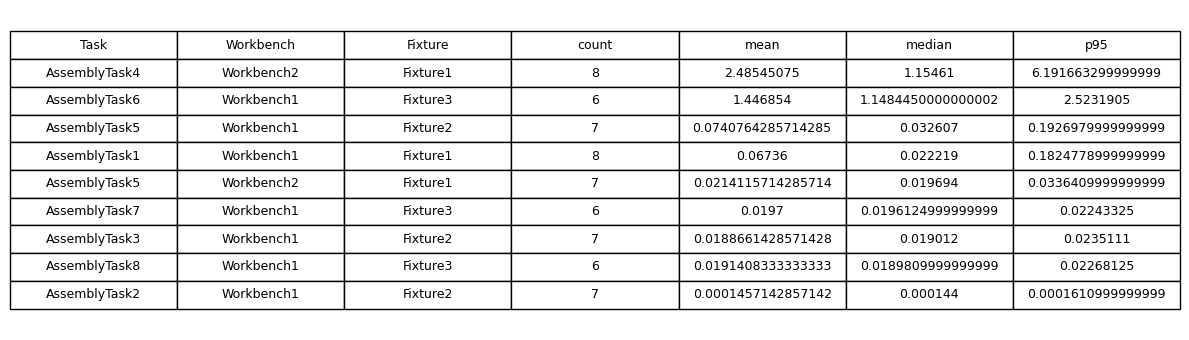

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("bottleneck_fixtures.csv")

# Πάρε τα top-10 (με βάση median)
top = df.sort_values("median", ascending=False).head(10).copy()

fig, ax = plt.subplots(figsize=(12, 3.5))
ax.axis("off")

table = ax.table(
    cellText=top.values,
    colLabels=top.columns,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.4)

plt.tight_layout()
plt.savefig("bottleneck_fixtures_top10.png", dpi=200)
plt.show()


In [ ]:
from google.colab import files
files.download("bottleneck_fixtures_top10.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>